In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.labelsize'] : 20
import nlopt
from scipy.stats import lognorm, chi2
from scipy.interpolate import UnivariateSpline

In [13]:
# Define parameters
a = np.zeros(3)
J = 1.0
D = 1.0
k = 1/10
σ = 1.0/2
x = np.linspace(0, 20, 21)   # Set up discretisation of truncated domain 0 < x < 20, with uniform mesh spacing of 1.0
xx = np.linspace(0, 20, 201)   # Set up fine discretisation of truncated domain 0 < x < 20, with uniform mesh spacing of 0.1

## Morphogen gradient model

### Reaction-diffusion equation for density $u(x,t) \ge 0$,

\begin{equation*}
\large{\dfrac{\partial u}{\partial t} =  D \dfrac{\partial^2 u}{\partial x^2} - k u,} \quad \textrm{on} \quad \large{x > 0.} 
\end{equation*}

### Initial condition

\begin{equation*}
\large{u(x,0)=0} \quad \textrm{on} \quad \large{x > 0.}
\end{equation*}

### Boundary conditions

\begin{align*}
\large{J} &\large{=-D \dfrac{\partial u}{\partial x}} \quad \textrm{at} \quad \large{x=0}, \notag \\
\large{u(x,t)} &\large{= 0,} \quad \textrm{as} \quad \large{x \to \infty}. \notag \\
\end{align*}

## Morphogen gradient model

### Long-time BVP $t \to \infty$

\begin{equation*}
\large{D\dfrac{\textrm{d}^2 U}{\textrm{d}x^2}-kU=0}, \quad \textrm{on} \quad \large{x > 0}.
\end{equation*}

### Boundary conditions

\begin{align*}
\large{J} &\large{=-D\dfrac{\textrm{d} U}{\textrm{d}x},} \quad \textrm{at} \quad \large{x=0}, \notag \\
\large{U} &\large{= 0,} \ \quad \textrm{as} \quad \large{x \to \infty.} \notag \\
\end{align*}

### Exact solution

\begin{equation*}
\large{U = \dfrac{J}{\sqrt{Dk}}\textrm{exp}\left(-x\sqrt{\dfrac{k}{D}}\right)}.
\end{equation*}



### Parameters

\begin{equation*}
\large{\theta = (D,k,J)^\top}.
\end{equation*}

In [14]:
def model(x, a):
    # Function to return the BVP solution at positions in the vector x
    coeff = a[0] / np.sqrt(a[1] * a[2])
    exponent_term = np.sqrt(a[2] / a[1])
    y = coeff * np.exp(-x * exponent_term)    
    return y

In [15]:
# Fixed data generated by solving the process model and corrupting the solution with multiplicative log‐normal noise with sigma=0.5 
data = np.array([3.898952675812746,
                 2.569825438525737,
                 1.206631819080483,
                 1.3543817108830818,
                 0.6175527058221386,
                 0.30785528929186456,
                 0.13649714414672498,
                 0.6921031114954066,
                 0.271392505145547,
                 0.0945662375934022,
                 0.06039757137011752,
                 0.1338145218277993,
                 0.1529291485263356,
                 0.05189445084962129,
                 0.02756210195622014,
                 0.018066943988933968,
                 0.017710583152626524,
                 0.009164129234587067,
                 0.008075081582671598,
                 0.010557776318846062,
                 0.004853780605374777])

## Noise model: Log-Normal 


\begin{equation*}
\large{U^{\textrm{obs}}(x_i) \mid \theta = \left[U(x_i) \mid \theta\right]\eta_i,} \quad \large{\eta_i \sim \textrm{log-normal} (0,\sigma^2).}
\end{equation*}


## Log-likelihood function

\begin{equation*}
	\large{\ell(\theta \mid U^\textrm{obs}(x_i)) = \sum_{i=1}^{I} \log \left[\phi\left(U^\textrm{obs}(x_i); \log(U(x_i)), \sigma^2 \right)\right]}.
\end{equation*}

In [16]:
def loglhood(data, a, sigma):
    # Evaluate the model solution with parameters a = [J, D, k]
    y = model(x, a)
    # Ensure valid values (avoid zero division)
    valid_mask = (y > 0) & (data > 0)
    if not np.any(valid_mask):
        return -np.inf  # If no valid data points, return negative infinity log-likelihood
    # Compute the ratio where both data and model values are valid
    ratio = data[valid_mask] / y[valid_mask]
    # Calculate log-likelihood using LogNormal PDF, with s=sigma and scale=1 (mean=0)
    log_likelihoods = lognorm.logpdf(ratio, sigma, scale=1)
    # Sum up all the log-likelihood values
    return np.sum(log_likelihoods)

In [17]:
a = np.zeros(3)
def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (J, D, k)
    return loglhood(data, a, σ)

In [18]:
def Optimise(fun, θ0, lb, ub):
    # Optimize finds the values of parameters theta that maximise the objective function fun with lower bounds lb, and upper bounds ub
    def tomax(theta, grad):
        return fun(theta)
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(1*60)
    xopt = opt.optimize(np.array(θ0))
    fopt = opt.last_optimum_value()
    return xopt, fopt

Time taken: 0.0420 seconds


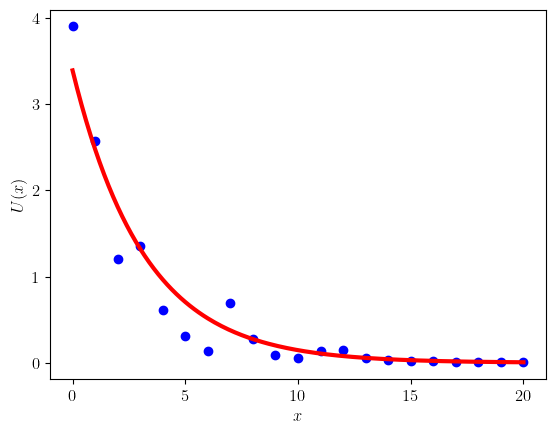

In [19]:
θG = [J, D, k]  # Initial parameter estimates for the iterative optimization solver 
lb = [0, 0, 0]  # lower bounds
ub = [1000, 1000, 1000]  # upper bounds

start = time.time()
xopt, fopt = Optimise(funmle, θG, lb, ub)  # Compute MLE and value of the log-likelihood at the MLE, print the time taken to optimize the solution
print("Time taken: {:.4f} seconds".format(time.time()-start))
Jmle = xopt[0]  # Store MLE
Dmle = xopt[1]  # Store MLE
kmle = xopt[2]  # Store MLE
fmle = fopt    # Store log-likelihood value at the MLE

def cmle(x_val):
    # MLE solution
    return xopt[0]*np.exp(-x_val*np.sqrt(xopt[2]/xopt[1]))/np.sqrt(xopt[1]*xopt[2])

# Plot the MLE solution on the data, Figure 6(a)
plt.figure()
plt.scatter(x, data, c='blue', label='_nolegend_')
plt.plot(xx, cmle(xx), color='red', linewidth=3, label='_nolegend_')
plt.xlabel(r"$x$",fontsize=12)
plt.ylabel(r"$U(x)$",fontsize=12)
plt.xlim(xx[0]-1, xx[-1]+1)
plt.xticks([0, 5, 10, 15, 20], [r"$0$", r"$5$", r"$10$", r"$15$", r"$20$"],fontsize=12)
plt.yticks([0, 1, 2, 3, 4], [r"$0$", r"$1$", r"$2$", r"$3$", r"$4$"],fontsize=12)
plt.tick_params(labelsize=12)
plt.show()

C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  coeff = a[0] / np.sqrt(a[1] * a[2])
C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  exponent_term = np.sqrt(a[2] / a[1])
C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:5: RuntimeWarning: invalid value encountered in multiply
  y = coeff * np.exp(-x * exponent_term)


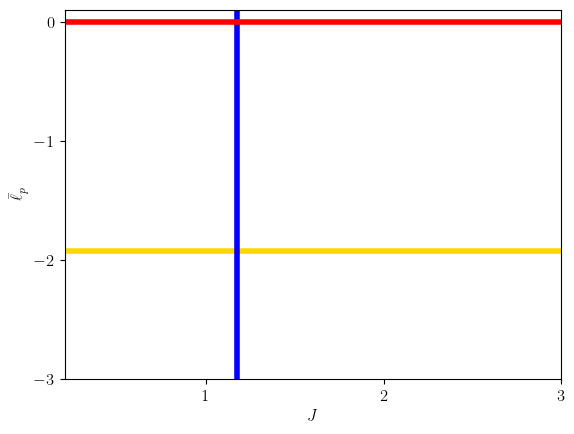

In [20]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

def univariateJ(J):
    # Function to compute the univariate profile likelihood for J
    a = np.zeros(2)
    def funJ(a):
        return loglhood(data, np.array([J, a[0], a[1]]), σ)  # evaluate the log-likelihood at a specified value of J
    θG_local = [Dmle, kmle]   # Estimate of the nuisance parameters D, k
    lb_local = [0.0, 0.0]     # Lower bounds of nuisance parameters D, k
    ub_local = [1000.0, 1000.0]  # Upper bounds of nuisance parameters D, k
    xopt_local, fopt_local = Optimise(funJ, θG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_J(x):
    return univariateJ(x)[0]  # Define function to compute the profile likelihood

M = 50  # Take a grid of M points to plot the univariate profile likelihood
Jrange = np.linspace(0.2, 3, M)
ff = np.zeros(M)
for i in range(M):
    ff[i] = univariateJ(Jrange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for J, superimposed with the MLE and 95% threshold
plt.figure()
plt.axhline(y=llstar, color='gold', linewidth=4)
plt.xlabel(r"$J$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12)
plt.axvline(x=Jmle, color='blue', linewidth=4)
spl = UnivariateSpline(Jrange, ff - np.max(ff), w=np.ones(len(Jrange)), k=1)
spl.set_smoothing_factor(1/100)
yy = spl(Jrange)
plt.plot(Jrange, yy, linewidth=4, color='red')
plt.ylim(-3, 0.1)
plt.xlim(Jrange[0], Jrange[-1])
plt.xticks([1, 2, 3], [r"$1$", r"$2$", r"$3$"],fontsize=12)
plt.yticks([0, -1, -2, -3], [r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
plt.tick_params(labelsize=12)
plt.show()

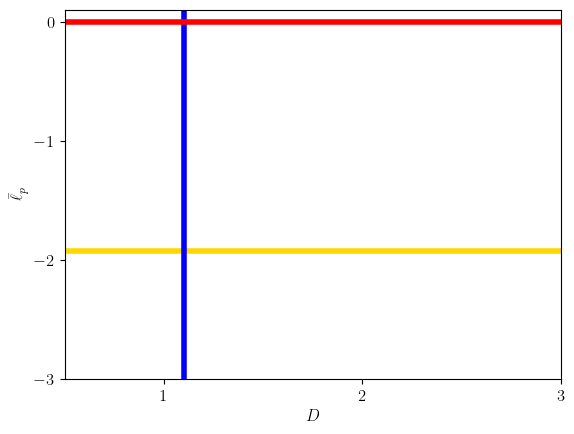

In [22]:
def univariateD(D):
    # Function to compute the univariate profile likelihood for D
    a = np.zeros(2)
    def funD(a):
        return loglhood(data, np.array([a[0], D, a[1]]), σ)  # evaluate the log-likelihood at a specified value of D
    θG_local = [Jmle, kmle]  # Estimate of the nuisance parameters J, k
    lb_local = [0.0, 0.0]    # Lower bounds of nuisance parameters J, k
    ub_local = [10.0, 100.0]  # Upper bounds of nuisance parameters J, k
    xopt_local, fopt_local = Optimise(funD, θG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_D(x):
    return univariateD(x)[0]  # Define function to compute the profile likelihood

M = 40  # Take a grid of M points to plot the univariate profile likelihood
Drange = np.linspace(0.5, 3, M)
ff_D = np.zeros(M)
for i in range(M):
    ff_D[i] = univariateD(Drange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for D, superimposed with the MLE and 95% threshold
plt.figure()
plt.axhline(y=llstar, color='gold', linewidth=4)
plt.xlabel(r"$D$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12)
plt.axvline(x=Dmle, color='blue', linewidth=4)
spl_D = UnivariateSpline(Drange, ff_D - np.max(ff_D), w=np.ones(len(Drange)), k=1)
spl_D.set_smoothing_factor(1/100)
yy_D = spl_D(Drange)
plt.plot(Drange, yy_D, linewidth=4, color='red')
plt.ylim(-3, 0.1)
plt.xlim(Drange[0], Drange[-1])
plt.xticks([1, 2, 3], [r"$1$", r"$2$", r"$3$"],fontsize=12)
plt.yticks([0, -1, -2, -3], [r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
plt.tick_params(labelsize=12)
plt.show()

C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  coeff = a[0] / np.sqrt(a[1] * a[2])
C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  exponent_term = np.sqrt(a[2] / a[1])
C:\Users\simpsom3\AppData\Local\Temp\ipykernel_6176\928827906.py:5: RuntimeWarning: invalid value encountered in multiply
  y = coeff * np.exp(-x * exponent_term)


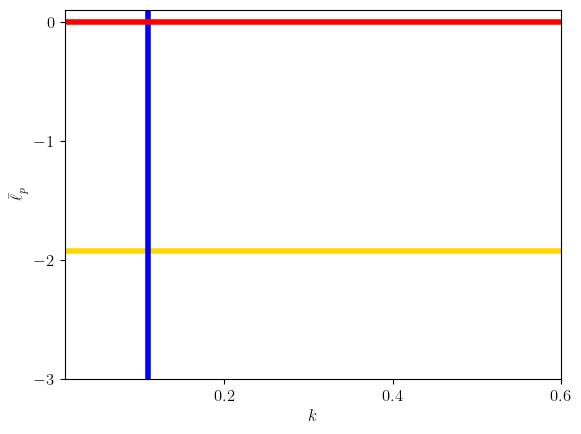

In [23]:
def univariatek(k_val):
    # Function to compute the univariate profile likelihood for k
    a = np.zeros(2)
    def funk(a):
        return loglhood(data, np.array([a[0], a[1], k_val]), σ)  # evaluate the log-likelihood at a specified value of k
    θG_local = [Jmle, Dmle]  # Estimate of the nuisance parameters J, D
    lb_local = [0.0, 0.0]   # Lower bounds of nuisance parameters J, D
    ub_local = [1000.0, 1000.0]  # Upper bounds of nuisance parameters J, D
    xopt_local, fopt_local = Optimise(funk, θG_local, lb_local, ub_local)
    return fopt_local, xopt_local  # Return the profile log-likelihood and value of the nuisance parameter

def f_k(x):
    return univariatek(x)[0]  # Define function to compute the profile likelihood

M = 50  # Take a grid of M points to plot the univariate profile likelihood
krange = np.linspace(0.01, 0.60, M)
ff_k = np.zeros(M)
for i in range(M):
    ff_k[i] = univariatek(krange[i])[0]  # Compute the profile log-likelihood over the M mesh points

# Plot the normalised profile log-likelihood for k, superimposed with the MLE and 95% threshold
plt.figure()
plt.axhline(y=llstar, color='gold', linewidth=4)
plt.xlabel(r"$k$",fontsize=12)
plt.ylabel(r"$\bar{\ell}_p$",fontsize=12)
plt.axvline(x=kmle, color='blue', linewidth=4)
spl_k = UnivariateSpline(krange, ff_k - np.max(ff_k), w=np.ones(len(krange)), k=1)
spl_k.set_smoothing_factor(1/100)
yy_k = spl_k(krange)
plt.plot(krange, yy_k, linewidth=4, color='red')
plt.ylim(-3, 0.1)
plt.xlim(krange[0], krange[-1])
plt.xticks([0.2, 0.4, 0.6], [r"$0.2$", r"$0.4$", r"$0.6$"],fontsize=12)
plt.yticks([0, -1, -2, -3], [r"$0$", r"$-1$", r"$-2$", r"$-3$"],fontsize=12)
plt.tick_params(labelsize=12)
plt.show()